<a href="https://colab.research.google.com/github/RachanaGusain/PahariLI/blob/main/PLI_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Language Identification

## Import Libraries

In [1]:
import os
import numpy as np
import csv
import pandas as pd
import regex as re
import sklearn
from time import time
from scipy import sparse
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE, MDS
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn import metrics
from collections import namedtuple, defaultdict, Counter, OrderedDict
from itertools import tee, islice, accumulate, combinations
from tabulate import tabulate
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
matplotlib.use("pgf")

plt.rcParams.update({
    "pgf.texsystem": 'pdflatex',
    "font.family": 'serif',  # use serif/main font for text elements
    "text.usetex": True,     # use inline math for ticks
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    "font.size": 8,          # Use 8pt font in plots, to match 10pt font in document
    "axes.titlesize": 8,
    "axes.labelsize": 8,
    "xtick.labelsize": 6,    # Make the legend/label fonts a little smaller
    "ytick.labelsize": 6,
    "xtick.major.size": 0,
    "ytick.major.size": 0,
    "xtick.major.width": 0.2,
    "ytick.major.width": 0.2,
    "xtick.minor.size" : 1.5,
    "xtick.minor.width": 0.2,
    "xtick.direction": 'in',
    "lines.markersize": 1.2,
    "lines.linewidth": 0.5,
    "hatch.linewidth": 0.4,
    "patch.linewidth": 0.2,
    "patch.edgecolor": 'k',
    "patch.facecolor": 'w',
    "axes.prop_cycle": matplotlib.cycler('color', 'k'),
    "hatch.color": 'k',
    "axes.linewidth": 0.2,
    "grid.linewidth": 0.2,
    "legend.fontsize": 6,
    "legend.title_fontsize": 6,
    "legend.labelspacing": 0.1,
    "legend.handlelength": 3,
    "legend.frameon": False,
    "savefig.dpi": 1000,
    "savefig.bbox": 'tight',
    "savefig.format": 'pdf'
    })

%matplotlib inline

In [ ]:
! sudo apt-get install texlive-latex-recommended 
! sudo apt install texlive-latex-extra
! sudo apt install dvipng
! sudo apt install cm-super
#!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-compute-11-1
  cuda-nsight-systems-10-1 cuda-nsight-systems-

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
num_clf = 2
clflist = ["mnb", "svm"]

## Load Data

In [ ]:
# Data files
tr_file = "/content/drive/MyDrive/PLI/data/train.txt"
ts_file = "/content/drive/MyDrive/PLI/data/test.txt"

# Load data
tr_data = open(tr_file, mode='r', encoding='utf-8')
ts_data = open(ts_file, mode='r', encoding='utf-8')

print("Data loaded.")

Data loaded.


In [ ]:
# Separate text and labels
tr_text = []
tr_lang = []
ts_text = []
ts_lang = []

for line in tr_data:
    text, lang = line.strip().split('\t')
    tr_text.append(text)
    tr_lang.append(lang)

for line in ts_data:
    text, lang = line.strip().split('\t')
    ts_text.append(text)
    ts_lang.append(lang)

In [ ]:
label = {'dgo': 0, 'gbm': 1, 'kfy': 2, 'npi': 3}

y_tr = np.asarray(list(map(lambda x: label[x], tr_lang)))
y_ts = np.asarray(list(map(lambda x: label[x], ts_lang)))

In [ ]:
def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6

tr_size_mb = size_mb(tr_text)
ts_size_mb = size_mb(ts_text)

print("Train data: %d sentences - %0.2f MB" % (len(tr_text), tr_size_mb))
print("Test data : %d sentences - %0.2f MB" % (len(ts_text), ts_size_mb))

Train data: 44014 sentences - 8.99 MB
Test data : 11004 sentences - 2.25 MB


In [26]:
corpus = namedtuple('corpus', ['data', 'target'])
PL_corpus = corpus(tr_text + ts_text, tr_lang + ts_lang)

print("Corpus size: %d sentences - %0.2f MB" 
      % (len(PL_corpus.data), size_mb(PL_corpus.data)))

PL = defaultdict(list)
for text, lang in zip(PL_corpus.data, PL_corpus.target):
    PL[lang].append(text)

Corpus size: 55018 sentences - 11.24 MB


In [28]:
# Overlapping token types among languages

types = defaultdict(list)
for lang in label.keys():
    lines = PL[lang]
    words = [word for line in lines for word in re.findall(r"[^\W\d]+", line)]  # discard numerals   
    types[lang] = set(words)

print(len(types['dgo'] & types['gbm'] & types['kfy'] & types['npi']))
print(types['dgo'] & types['gbm'] & types['kfy'] & types['npi'])

{'खाली', 'विश्राम', 'उत्सव', 'खान', 'एस', 'यदि', 'भजन', 'व्यापार', 'योग', 'भूमि', 'टीम', 'राम', 'खतरनाक', 'कागज', 'सीमित', 'खुलेआम', 'खोई', 'छे', 'कारण', 'मध्यम', 'चिठ्ठी', 'यहूदी', 'कर्नाटक', 'ब्रिगेड', 'रेखा', 'प्रभाव', 'गीत', 'जान', 'आम', 'युग', 'आदेश', 'बोली', 'सप्ताह', 'बहुत', 'संगीत', 'घृणा', 'रचनात्मक', 'दै', 'पार्टी', 'नियम', 'बिलकुल', 'याकूब', 'खर्च', 'बोले', 'भण्डार', 'रिपोर्ट', 'निवास', 'आराम', 'सिपाही', 'प्राण', 'मालिक', 'विद्वान', 'डिग्री', 'महाराष्ट्र', 'बच्चा', 'अजय', 'फोटो', 'जनरल', 'ख्याल', 'जमात', 'स्वाद', 'खुशी', 'ध्यान', 'फर', 'लेक', 'काम', 'कसम', 'जा', 'साल', 'सूचना', 'चिन्ता', 'विजेता', 'वर्ग', 'समय', 'आ', 'सभ्यता', 'आदर', 'लेन', 'चार', 'होली', 'घर', 'रात', 'सुन', 'नौ', 'किलोमीटर', 'गई', 'तम्बू', 'चकित', 'पोल', 'दुष्ट', 'सफल', 'विभाग', 'कल', 'सवारी', 'वीर', 'पिता', 'हाजिर', 'वाक्य', 'जंगली', 'कृषि', 'बार', 'कार', 'प्रतीक्षा', 'दुखी', 'सिलास', 'ऋतु', 'निकाली', 'रे', 'कविता', 'भीख', 'बोर्ड', 'ले', 'इन्कार', 'जोर', 'फूट', 'क्षमा', 'अत्याचार', 'सेवन', 'सामरी', 'झट्ट',

## Language Identification

In [ ]:
def ngrams(term, ngram_range, min_df=1, max_df=1.0):
    """
    Function to extract word or char n-gram features.

    Parameters:
        analyzer: string {'word', 'char', 'char_wb'}
            Whether the feature should be made of word n-gram or character n-grams.
            Option 'char_wb' creates character n-grams only from text inside word boundaries;
            n-grams at the edges of words are padded with space.

        ngram_range: tuple (min_n, max_n), default=(1, 1)
            The lower and upper boundary of the range of n-values for different n-grams to be extracted.
            All values of n such that min_n <= n <= max_n will be used.
            For example an ngram_range of (1, 1) means only unigrams, (1, 2) means unigrams and bigrams, and (2, 2) means only bigrams.

        min_df: float in range [0.0, 1.0] or int, default=1
            When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold.
            This value is also called cut-off in the literature.
            If float, the parameter represents a proportion of documents, integer absolute counts.

        max_df: float in range [0.0, 1.0] or int, default=1.0
            When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words).
            If float, the parameter represents a proportion of documents, integer absolute counts.

    Returns:
        z: dict {features: list of features, tr_analyzer_ngram: scipy.sparse.csr.csr_matrix, ts_analyzer_ngram: scipy.sparse.csr.csr_matrix}
    """
    
    i, j = ngram_range
    
    def word_ngram_analyzer(doc):
        for line in doc.split('\n'):
            terms = re.findall(r"\w+", line)
            for n in range(i, j+1):
                for ngram in zip(*[islice(seq, k, len(terms)) for k, seq in enumerate(tee(terms, n))]):
                    ngram = " ".join(ngram)
                    yield ngram
    
    try:
        if term == 'word':
            vectorizer = CountVectorizer(analyzer=word_ngram_analyzer, min_df=min_df, max_df=max_df)
        else:
            vectorizer = CountVectorizer(analyzer=term, ngram_range=(i, j), min_df=min_df, max_df=max_df)
        vectorizer.fit(tr_text)
    except ValueError:
        print("Error: After pruning, no terms remain.")
        return None

    z = dict()
    z["features"] = vectorizer.get_feature_names_out()
    z["tr_"+term+"_"+str(i)+str(j)] = vectorizer.transform(tr_text)
    z["ts_"+term+"_"+str(i)+str(j)] = vectorizer.transform(ts_text)

    return z

In [ ]:
def classifier(clf, params, X_tr, y_tr, X_ts, y_ts):
    print("Training", clf)

    search = GridSearchCV(estimator=clf, param_grid=params, scoring='accuracy', 
                          cv=5, verbose=1, return_train_score=True)
    t0 = time()
    search.fit(X_tr, y_tr)
    tr_val_time = time() - t0
    clf = search.best_estimator_
    print("\nBest Estimator:", clf)
    print("\nTrain and validation time: %.4f seconds" % tr_val_time)

    t0 = time()
    y_true, y_pred = y_ts, clf.predict(X_ts)
    ts_time = time() - t0
    print("\nTest time: %.4f seconds" % ts_time)

    confusion_mat = metrics.confusion_matrix(y_true, y_pred)
    scores_report = metrics.classification_report(y_true, y_pred, target_names=label.keys(), output_dict=True)
    scores_report = pd.DataFrame(scores_report)
    
    print("\nClassification report:")
    print(metrics.classification_report(y_true, y_pred, target_names=label.keys(), digits=4))
    print("\nConfusion matrix:")
    cm_disp = metrics.ConfusionMatrixDisplay.from_estimator(clf, X_ts, y_ts, values_format='d', 
                                                           display_labels=label.keys(), cmap=plt.cm.Blues, colorbar=False)
    
    plt.show()

    return search.best_params_, tr_val_time, ts_time, scores_report, cm_disp, y_pred

In [ ]:
def build_ngram_model(max_n):
    ngram = range(1, max_n+1)
    ngram_range = [(i, j) for i in ngram for j in ngram if i<=j]

    outputs = {clf: dict() for clf in clflist}
    results = {clf: [] for clf in clflist}
    columns = ["Vectorizer", "#Features", "Hyperparameter", 
               "Train&Val time (s)", "Test time (s)", 
               "Precision", "Recall", "F1-score", "Accuracy"]

    for analyzer in ['word', 'char', 'char_wb']:
        for (i, j) in ngram_range:
            print('*'*80)
            print(f"Extracting frequency based {analyzer} ({i},{j})-gram features...")
            z = ngrams(term=analyzer, ngram_range=(i, j), min_df=0.005)
            if z is None:          
                continue
            
            vect = analyzer+"_"+str(i)+str(j)
            X_tr = z["tr_"+vect].toarray()
            X_ts = z["ts_"+vect].toarray()

            for (clf, params, descript), clfname in zip([
                    (MultinomialNB(), 
                     {'alpha': np.power(10, np.arange(-3, 2, dtype=float))}, 
                     "Multinomial Naïve Bayes Classifier"),
                    (LinearSVC(dual=False), 
                     {'C': np.power(10, np.arange(-3, 2, dtype=float))}, 
                     "Linear Support Vector Classifier")], 
                    clflist):
                best_param, tr_val_time, ts_time, scores, cm_disp, y_pred = classifier(clf, params, X_tr, y_tr, X_ts, y_ts)
                cm_df = pd.DataFrame(cm_disp.confusion_matrix, index=label.keys(), columns=label.keys())
                cm_df.to_csv(os.path.join(dirpath, 'confusion_matrix', 'cm_'+clfname+'_'+vect+'.csv'))
                result = []
                result.extend([vect, len(z["features"])])          
                result.extend(best_param.values())                 
                result.extend([tr_val_time, ts_time])               
                result.extend(scores["macro avg"].tolist()[:-1])   
                result.append(scores["accuracy"].iat[0]*100)
                results[clfname].append(dict(zip(columns, result)))
                outputs[clfname][vect] = y_pred

    return {clf: pd.DataFrame(results[clf]) for clf in clflist}, outputs

********************************************************************************
Extracting frequency based word (1,1)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.01)

Train and validation time: 13.5772 seconds

Test time: 0.0235 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9757    0.9835    0.9796      2004
         gbm     0.8658    0.9740    0.9167      3000
         kfy     0.9612    0.9250    0.9428      3000
         npi     0.9842    0.8930    0.9364      3000

    accuracy                         0.9403     11004
   macro avg     0.9467    0.9439    0.9439     11004
weighted avg     0.9441    0.9403    0.9406     11004


Confusion matrix:


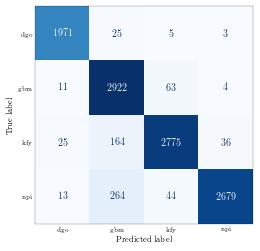

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(dual=False)

Train and validation time: 14.9521 seconds

Test time: 0.0214 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9899    0.9765    0.9832      2004
         gbm     0.9675    0.9533    0.9604      3000
         kfy     0.9627    0.9303    0.9463      3000
         npi     0.9363    0.9900    0.9624      3000

    accuracy                         0.9613     11004
   macro avg     0.9641    0.9626    0.9631     11004
weighted avg     0.9618    0.9613    0.9612     11004


Confusion matrix:


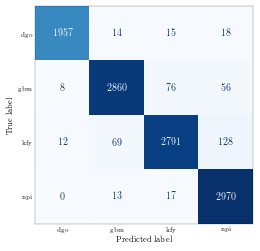

********************************************************************************
Extracting frequency based word (1,2)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.01)

Train and validation time: 17.2733 seconds

Test time: 0.0245 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9762    0.9835    0.9799      2004
         gbm     0.8658    0.9740    0.9167      3000
         kfy     0.9612    0.9253    0.9429      3000
         npi     0.9842    0.8930    0.9364      3000

    accuracy                         0.9404     11004
   macro avg     0.9469    0.9440    0.9440     11004
weighted avg     0.9442    0.9404    0.9407     11004


Confusion matrix:


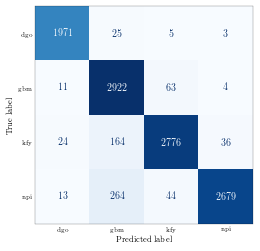

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(dual=False)

Train and validation time: 17.8175 seconds

Test time: 0.0368 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9899    0.9770    0.9834      2004
         gbm     0.9675    0.9533    0.9604      3000
         kfy     0.9631    0.9303    0.9464      3000
         npi     0.9363    0.9900    0.9624      3000

    accuracy                         0.9614     11004
   macro avg     0.9642    0.9627    0.9632     11004
weighted avg     0.9619    0.9614    0.9613     11004


Confusion matrix:


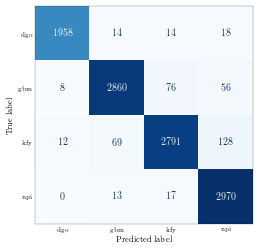

********************************************************************************
Extracting frequency based word (1,3)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.01)

Train and validation time: 17.3822 seconds

Test time: 0.0227 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9762    0.9835    0.9799      2004
         gbm     0.8658    0.9740    0.9167      3000
         kfy     0.9612    0.9253    0.9429      3000
         npi     0.9842    0.8930    0.9364      3000

    accuracy                         0.9404     11004
   macro avg     0.9469    0.9440    0.9440     11004
weighted avg     0.9442    0.9404    0.9407     11004


Confusion matrix:


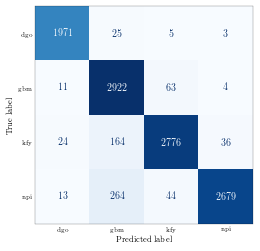

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(dual=False)

Train and validation time: 14.5674 seconds

Test time: 0.0231 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9899    0.9770    0.9834      2004
         gbm     0.9675    0.9533    0.9604      3000
         kfy     0.9631    0.9303    0.9464      3000
         npi     0.9363    0.9900    0.9624      3000

    accuracy                         0.9614     11004
   macro avg     0.9642    0.9627    0.9632     11004
weighted avg     0.9619    0.9614    0.9613     11004


Confusion matrix:


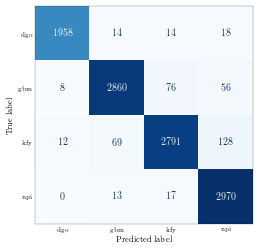

********************************************************************************
Extracting frequency based word (1,4)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.01)

Train and validation time: 14.9073 seconds

Test time: 0.0251 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9762    0.9835    0.9799      2004
         gbm     0.8658    0.9740    0.9167      3000
         kfy     0.9612    0.9253    0.9429      3000
         npi     0.9842    0.8930    0.9364      3000

    accuracy                         0.9404     11004
   macro avg     0.9469    0.9440    0.9440     11004
weighted avg     0.9442    0.9404    0.9407     11004


Confusion matrix:


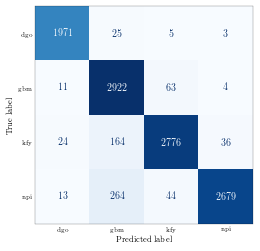

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(dual=False)

Train and validation time: 20.9344 seconds

Test time: 0.0258 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9899    0.9770    0.9834      2004
         gbm     0.9675    0.9533    0.9604      3000
         kfy     0.9631    0.9303    0.9464      3000
         npi     0.9363    0.9900    0.9624      3000

    accuracy                         0.9614     11004
   macro avg     0.9642    0.9627    0.9632     11004
weighted avg     0.9619    0.9614    0.9613     11004


Confusion matrix:


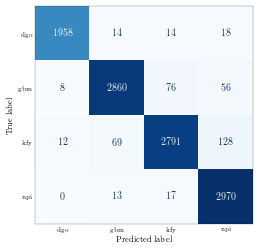

********************************************************************************
Extracting frequency based word (1,5)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.01)

Train and validation time: 17.1742 seconds

Test time: 0.0230 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9762    0.9835    0.9799      2004
         gbm     0.8658    0.9740    0.9167      3000
         kfy     0.9612    0.9253    0.9429      3000
         npi     0.9842    0.8930    0.9364      3000

    accuracy                         0.9404     11004
   macro avg     0.9469    0.9440    0.9440     11004
weighted avg     0.9442    0.9404    0.9407     11004


Confusion matrix:


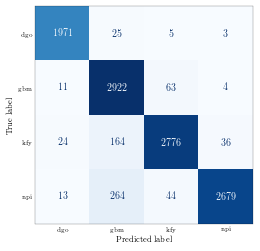

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(dual=False)

Train and validation time: 14.5993 seconds

Test time: 0.0256 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9899    0.9770    0.9834      2004
         gbm     0.9675    0.9533    0.9604      3000
         kfy     0.9631    0.9303    0.9464      3000
         npi     0.9363    0.9900    0.9624      3000

    accuracy                         0.9614     11004
   macro avg     0.9642    0.9627    0.9632     11004
weighted avg     0.9619    0.9614    0.9613     11004


Confusion matrix:


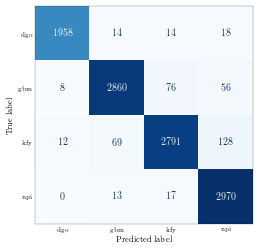

********************************************************************************
Extracting frequency based word (1,6)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.01)

Train and validation time: 16.4604 seconds

Test time: 0.0238 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9762    0.9835    0.9799      2004
         gbm     0.8658    0.9740    0.9167      3000
         kfy     0.9612    0.9253    0.9429      3000
         npi     0.9842    0.8930    0.9364      3000

    accuracy                         0.9404     11004
   macro avg     0.9469    0.9440    0.9440     11004
weighted avg     0.9442    0.9404    0.9407     11004


Confusion matrix:


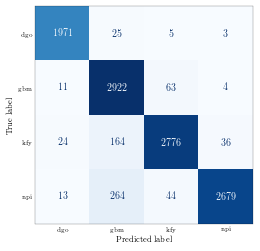

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(dual=False)

Train and validation time: 14.6386 seconds

Test time: 0.0246 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9899    0.9770    0.9834      2004
         gbm     0.9675    0.9533    0.9604      3000
         kfy     0.9631    0.9303    0.9464      3000
         npi     0.9363    0.9900    0.9624      3000

    accuracy                         0.9614     11004
   macro avg     0.9642    0.9627    0.9632     11004
weighted avg     0.9619    0.9614    0.9613     11004


Confusion matrix:


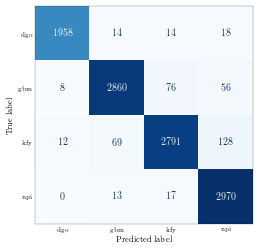

********************************************************************************
Extracting frequency based word (1,7)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.01)

Train and validation time: 16.0579 seconds

Test time: 0.0230 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9762    0.9835    0.9799      2004
         gbm     0.8658    0.9740    0.9167      3000
         kfy     0.9612    0.9253    0.9429      3000
         npi     0.9842    0.8930    0.9364      3000

    accuracy                         0.9404     11004
   macro avg     0.9469    0.9440    0.9440     11004
weighted avg     0.9442    0.9404    0.9407     11004


Confusion matrix:


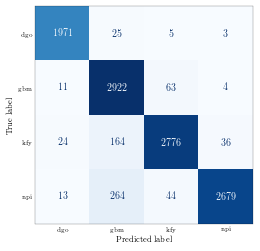

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(dual=False)

Train and validation time: 14.8158 seconds

Test time: 0.0210 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9899    0.9770    0.9834      2004
         gbm     0.9675    0.9533    0.9604      3000
         kfy     0.9631    0.9303    0.9464      3000
         npi     0.9363    0.9900    0.9624      3000

    accuracy                         0.9614     11004
   macro avg     0.9642    0.9627    0.9632     11004
weighted avg     0.9619    0.9614    0.9613     11004


Confusion matrix:


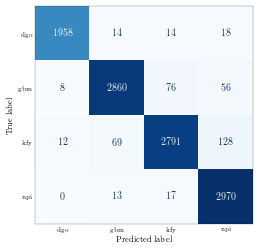

********************************************************************************
Extracting frequency based word (1,8)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.01)

Train and validation time: 17.5388 seconds

Test time: 0.0218 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9762    0.9835    0.9799      2004
         gbm     0.8658    0.9740    0.9167      3000
         kfy     0.9612    0.9253    0.9429      3000
         npi     0.9842    0.8930    0.9364      3000

    accuracy                         0.9404     11004
   macro avg     0.9469    0.9440    0.9440     11004
weighted avg     0.9442    0.9404    0.9407     11004


Confusion matrix:


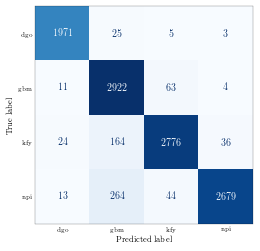

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(dual=False)

Train and validation time: 17.7204 seconds

Test time: 0.0263 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9899    0.9770    0.9834      2004
         gbm     0.9675    0.9533    0.9604      3000
         kfy     0.9631    0.9303    0.9464      3000
         npi     0.9363    0.9900    0.9624      3000

    accuracy                         0.9614     11004
   macro avg     0.9642    0.9627    0.9632     11004
weighted avg     0.9619    0.9614    0.9613     11004


Confusion matrix:


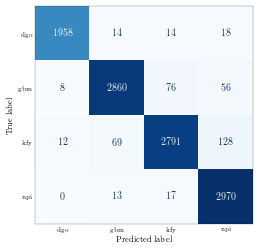

********************************************************************************
Extracting frequency based word (2,2)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.001)

Train and validation time: 1.1013 seconds

Test time: 0.0019 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     1.0000    0.1223    0.2179      2004
         gbm     0.2839    0.9963    0.4419      3000
         kfy     0.0000    0.0000    0.0000      3000
         npi     0.0000    0.0000    0.0000      3000

    accuracy                         0.2939     11004
   macro avg     0.3210    0.2796    0.1649     11004
weighted avg     0.2595    0.2939    0.1602     11004


Confusion matrix:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

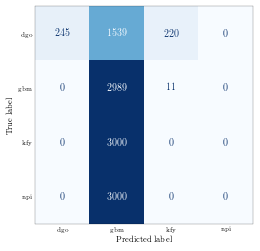

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.01, dual=False)

Train and validation time: 13.7834 seconds

Test time: 0.0032 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9769    0.2320    0.3750      2004
         gbm     0.9870    0.0507    0.0964      3000
         kfy     0.0000    0.0000    0.0000      3000
         npi     0.2892    1.0000    0.4486      3000

    accuracy                         0.3287     11004
   macro avg     0.5633    0.3207    0.2300     11004
weighted avg     0.5258    0.3287    0.2169     11004


Confusion matrix:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

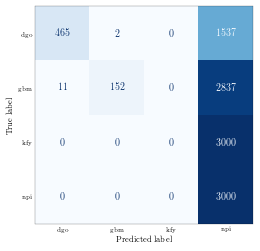

********************************************************************************
Extracting frequency based word (2,3)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.001)

Train and validation time: 1.0205 seconds

Test time: 0.0030 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     1.0000    0.1223    0.2179      2004
         gbm     0.2839    0.9963    0.4419      3000
         kfy     0.0000    0.0000    0.0000      3000
         npi     0.0000    0.0000    0.0000      3000

    accuracy                         0.2939     11004
   macro avg     0.3210    0.2796    0.1649     11004
weighted avg     0.2595    0.2939    0.1602     11004


Confusion matrix:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

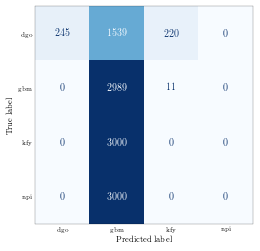

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.01, dual=False)

Train and validation time: 13.1242 seconds

Test time: 0.0015 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9769    0.2320    0.3750      2004
         gbm     0.9870    0.0507    0.0964      3000
         kfy     0.0000    0.0000    0.0000      3000
         npi     0.2892    1.0000    0.4486      3000

    accuracy                         0.3287     11004
   macro avg     0.5633    0.3207    0.2300     11004
weighted avg     0.5258    0.3287    0.2169     11004


Confusion matrix:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

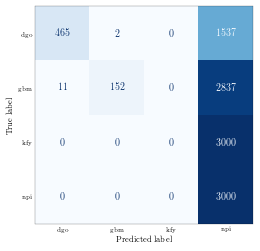

********************************************************************************
Extracting frequency based word (2,4)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.001)

Train and validation time: 1.2455 seconds

Test time: 0.0020 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     1.0000    0.1223    0.2179      2004
         gbm     0.2839    0.9963    0.4419      3000
         kfy     0.0000    0.0000    0.0000      3000
         npi     0.0000    0.0000    0.0000      3000

    accuracy                         0.2939     11004
   macro avg     0.3210    0.2796    0.1649     11004
weighted avg     0.2595    0.2939    0.1602     11004


Confusion matrix:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

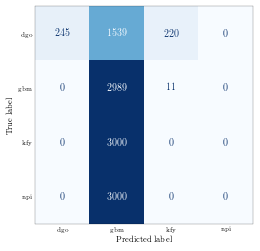

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.01, dual=False)

Train and validation time: 12.6450 seconds

Test time: 0.0022 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9769    0.2320    0.3750      2004
         gbm     0.9870    0.0507    0.0964      3000
         kfy     0.0000    0.0000    0.0000      3000
         npi     0.2892    1.0000    0.4486      3000

    accuracy                         0.3287     11004
   macro avg     0.5633    0.3207    0.2300     11004
weighted avg     0.5258    0.3287    0.2169     11004


Confusion matrix:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

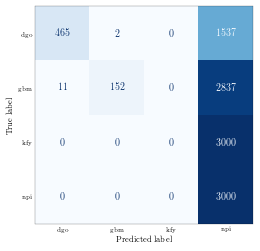

********************************************************************************
Extracting frequency based word (2,5)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.001)

Train and validation time: 1.2479 seconds

Test time: 0.0014 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     1.0000    0.1223    0.2179      2004
         gbm     0.2839    0.9963    0.4419      3000
         kfy     0.0000    0.0000    0.0000      3000
         npi     0.0000    0.0000    0.0000      3000

    accuracy                         0.2939     11004
   macro avg     0.3210    0.2796    0.1649     11004
weighted avg     0.2595    0.2939    0.1602     11004


Confusion matrix:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

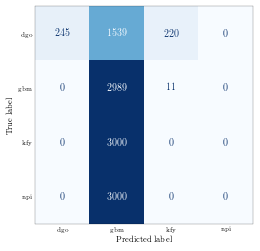

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.01, dual=False)

Train and validation time: 13.8477 seconds

Test time: 0.0035 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9769    0.2320    0.3750      2004
         gbm     0.9870    0.0507    0.0964      3000
         kfy     0.0000    0.0000    0.0000      3000
         npi     0.2892    1.0000    0.4486      3000

    accuracy                         0.3287     11004
   macro avg     0.5633    0.3207    0.2300     11004
weighted avg     0.5258    0.3287    0.2169     11004


Confusion matrix:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

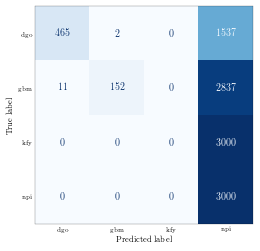

********************************************************************************
Extracting frequency based word (2,6)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.001)

Train and validation time: 1.6915 seconds

Test time: 0.0025 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     1.0000    0.1223    0.2179      2004
         gbm     0.2839    0.9963    0.4419      3000
         kfy     0.0000    0.0000    0.0000      3000
         npi     0.0000    0.0000    0.0000      3000

    accuracy                         0.2939     11004
   macro avg     0.3210    0.2796    0.1649     11004
weighted avg     0.2595    0.2939    0.1602     11004


Confusion matrix:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

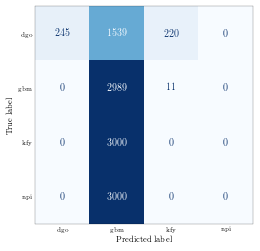

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.01, dual=False)

Train and validation time: 14.3982 seconds

Test time: 0.0015 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9769    0.2320    0.3750      2004
         gbm     0.9870    0.0507    0.0964      3000
         kfy     0.0000    0.0000    0.0000      3000
         npi     0.2892    1.0000    0.4486      3000

    accuracy                         0.3287     11004
   macro avg     0.5633    0.3207    0.2300     11004
weighted avg     0.5258    0.3287    0.2169     11004


Confusion matrix:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

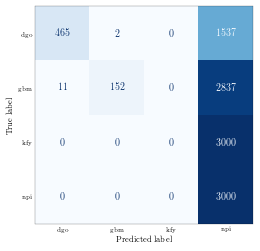

********************************************************************************
Extracting frequency based word (2,7)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.001)

Train and validation time: 1.2512 seconds

Test time: 0.0016 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     1.0000    0.1223    0.2179      2004
         gbm     0.2839    0.9963    0.4419      3000
         kfy     0.0000    0.0000    0.0000      3000
         npi     0.0000    0.0000    0.0000      3000

    accuracy                         0.2939     11004
   macro avg     0.3210    0.2796    0.1649     11004
weighted avg     0.2595    0.2939    0.1602     11004


Confusion matrix:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

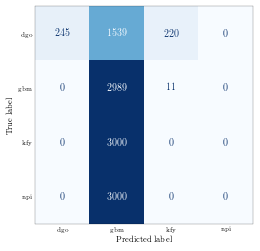

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.01, dual=False)

Train and validation time: 13.1552 seconds

Test time: 0.0046 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9769    0.2320    0.3750      2004
         gbm     0.9870    0.0507    0.0964      3000
         kfy     0.0000    0.0000    0.0000      3000
         npi     0.2892    1.0000    0.4486      3000

    accuracy                         0.3287     11004
   macro avg     0.5633    0.3207    0.2300     11004
weighted avg     0.5258    0.3287    0.2169     11004


Confusion matrix:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

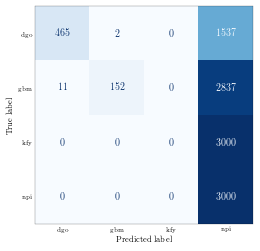

********************************************************************************
Extracting frequency based word (2,8)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.001)

Train and validation time: 1.7665 seconds

Test time: 0.0015 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     1.0000    0.1223    0.2179      2004
         gbm     0.2839    0.9963    0.4419      3000
         kfy     0.0000    0.0000    0.0000      3000
         npi     0.0000    0.0000    0.0000      3000

    accuracy                         0.2939     11004
   macro avg     0.3210    0.2796    0.1649     11004
weighted avg     0.2595    0.2939    0.1602     11004


Confusion matrix:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

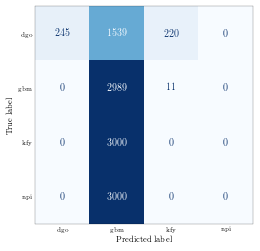

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.01, dual=False)

Train and validation time: 13.2958 seconds

Test time: 0.0036 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9769    0.2320    0.3750      2004
         gbm     0.9870    0.0507    0.0964      3000
         kfy     0.0000    0.0000    0.0000      3000
         npi     0.2892    1.0000    0.4486      3000

    accuracy                         0.3287     11004
   macro avg     0.5633    0.3207    0.2300     11004
weighted avg     0.5258    0.3287    0.2169     11004


Confusion matrix:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

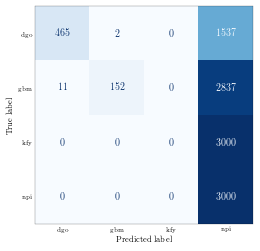

********************************************************************************
Extracting frequency based word (3,3)-gram features...
Error: After pruning, no terms remain.
********************************************************************************
Extracting frequency based word (3,4)-gram features...
Error: After pruning, no terms remain.
********************************************************************************
Extracting frequency based word (3,5)-gram features...
Error: After pruning, no terms remain.
********************************************************************************
Extracting frequency based word (3,6)-gram features...
Error: After pruning, no terms remain.
********************************************************************************
Extracting frequency based word (3,7)-gram features...
Error: After pruning, no terms remain.
********************************************************************************
Extracting frequency based word (3,8)-gram f

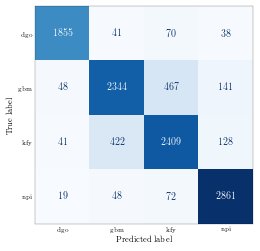

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(dual=False)

Train and validation time: 63.5594 seconds

Test time: 0.0130 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9569    0.9406    0.9487      2004
         gbm     0.8408    0.8360    0.8384      3000
         kfy     0.8356    0.8350    0.8353      3000
         npi     0.9574    0.9743    0.9658      3000

    accuracy                         0.8925     11004
   macro avg     0.8976    0.8965    0.8970     11004
weighted avg     0.8923    0.8925    0.8924     11004


Confusion matrix:


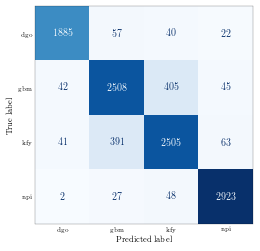

********************************************************************************
Extracting frequency based char (1,2)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.001)

Train and validation time: 69.2224 seconds

Test time: 0.0779 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9909    0.9830    0.9870      2004
         gbm     0.9619    0.9520    0.9569      3000
         kfy     0.9563    0.9563    0.9563      3000
         npi     0.9783    0.9937    0.9859      3000

    accuracy                         0.9702     11004
   macro avg     0.9719    0.9713    0.9715     11004
weighted avg     0.9702    0.9702    0.9702     11004


Confusion matrix:


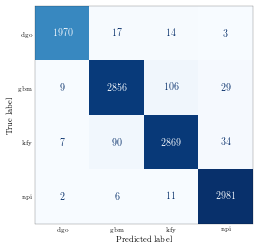

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.1, dual=False)

Train and validation time: 137.3730 seconds

Test time: 0.1308 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9935    0.9925    0.9930      2004
         gbm     0.9796    0.9763    0.9780      3000
         kfy     0.9731    0.9780    0.9756      3000
         npi     0.9950    0.9940    0.9945      3000

    accuracy                         0.9846     11004
   macro avg     0.9853    0.9852    0.9853     11004
weighted avg     0.9846    0.9846    0.9846     11004


Confusion matrix:


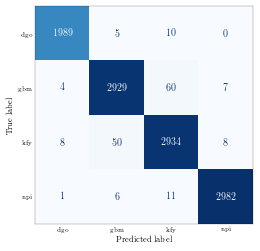

********************************************************************************
Extracting frequency based char (1,3)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.001)

Train and validation time: 216.0242 seconds

Test time: 0.2485 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9955    0.9940    0.9948      2004
         gbm     0.9767    0.9787    0.9777      3000
         kfy     0.9806    0.9753    0.9779      3000
         npi     0.9934    0.9977    0.9955      3000

    accuracy                         0.9857     11004
   macro avg     0.9865    0.9864    0.9865     11004
weighted avg     0.9857    0.9857    0.9857     11004


Confusion matrix:


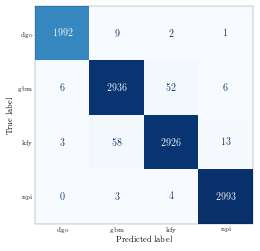

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.01, dual=False)

Train and validation time: 167.7902 seconds

Test time: 0.3124 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9980    0.9955    0.9968      2004
         gbm     0.9887    0.9887    0.9887      3000
         kfy     0.9850    0.9880    0.9865      3000
         npi     0.9983    0.9970    0.9977      3000

    accuracy                         0.9920     11004
   macro avg     0.9925    0.9923    0.9924     11004
weighted avg     0.9920    0.9920    0.9920     11004


Confusion matrix:


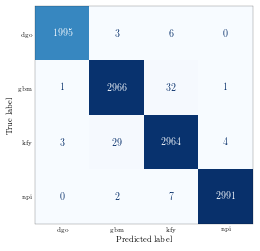

********************************************************************************
Extracting frequency based char (1,4)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.001)

Train and validation time: 301.9154 seconds

Test time: 0.5639 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9980    0.9970    0.9975      2004
         gbm     0.9826    0.9813    0.9820      3000
         kfy     0.9816    0.9800    0.9808      3000
         npi     0.9954    0.9990    0.9972      3000

    accuracy                         0.9886     11004
   macro avg     0.9894    0.9893    0.9894     11004
weighted avg     0.9886    0.9886    0.9886     11004


Confusion matrix:


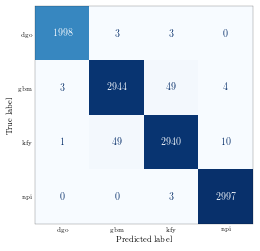

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.01, dual=False)

Train and validation time: 179.1981 seconds

Test time: 0.3961 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9995    0.9960    0.9978      2004
         gbm     0.9900    0.9883    0.9892      3000
         kfy     0.9854    0.9900    0.9877      3000
         npi     0.9987    0.9980    0.9983      3000

    accuracy                         0.9928     11004
   macro avg     0.9934    0.9931    0.9932     11004
weighted avg     0.9928    0.9928    0.9928     11004


Confusion matrix:


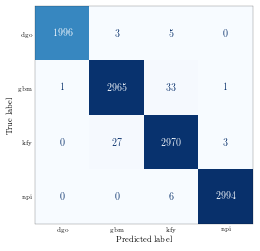

********************************************************************************
Extracting frequency based char (1,5)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.001)

Train and validation time: 715.6917 seconds

Test time: 0.4904 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9975    0.9975    0.9975      2004
         gbm     0.9830    0.9813    0.9822      3000
         kfy     0.9816    0.9803    0.9810      3000
         npi     0.9957    0.9987    0.9972      3000

    accuracy                         0.9887     11004
   macro avg     0.9894    0.9895    0.9895     11004
weighted avg     0.9887    0.9887    0.9887     11004


Confusion matrix:


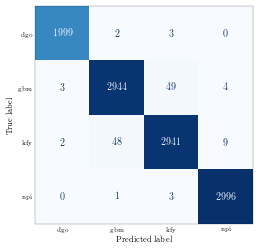

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.1, dual=False)

Train and validation time: 202.3654 seconds

Test time: 0.4701 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9985    0.9960    0.9973      2004
         gbm     0.9896    0.9870    0.9883      3000
         kfy     0.9838    0.9893    0.9865      3000
         npi     0.9990    0.9977    0.9983      3000

    accuracy                         0.9922     11004
   macro avg     0.9927    0.9925    0.9926     11004
weighted avg     0.9922    0.9922    0.9922     11004


Confusion matrix:


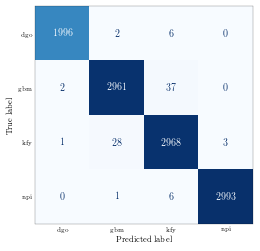

********************************************************************************
Extracting frequency based char (1,6)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.001)

Train and validation time: 502.8298 seconds

Test time: 0.4779 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9970    0.9970    0.9970      2004
         gbm     0.9830    0.9810    0.9820      3000
         kfy     0.9813    0.9800    0.9807      3000
         npi     0.9953    0.9987    0.9970      3000

    accuracy                         0.9885     11004
   macro avg     0.9892    0.9892    0.9892     11004
weighted avg     0.9884    0.9885    0.9885     11004


Confusion matrix:


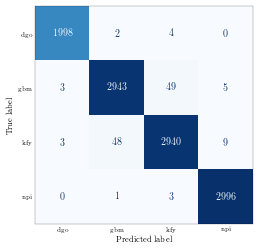

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.1, dual=False)

Train and validation time: 206.8098 seconds

Test time: 0.5657 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9985    0.9960    0.9973      2004
         gbm     0.9896    0.9867    0.9881      3000
         kfy     0.9834    0.9893    0.9864      3000
         npi     0.9990    0.9977    0.9983      3000

    accuracy                         0.9921     11004
   macro avg     0.9926    0.9924    0.9925     11004
weighted avg     0.9921    0.9921    0.9921     11004


Confusion matrix:


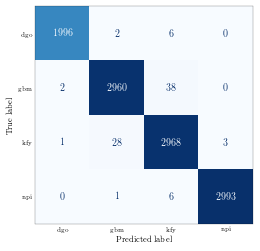

********************************************************************************
Extracting frequency based char (1,7)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.001)

Train and validation time: 1068.7029 seconds

Test time: 0.6011 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9975    0.9970    0.9973      2004
         gbm     0.9830    0.9807    0.9818      3000
         kfy     0.9813    0.9803    0.9808      3000
         npi     0.9950    0.9987    0.9968      3000

    accuracy                         0.9885     11004
   macro avg     0.9892    0.9892    0.9892     11004
weighted avg     0.9884    0.9885    0.9885     11004


Confusion matrix:


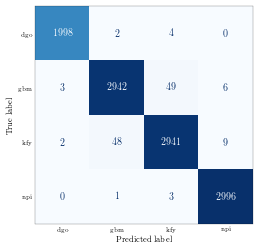

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.1, dual=False)

Train and validation time: 214.3979 seconds

Test time: 0.4998 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9985    0.9960    0.9973      2004
         gbm     0.9896    0.9867    0.9881      3000
         kfy     0.9834    0.9893    0.9864      3000
         npi     0.9990    0.9977    0.9983      3000

    accuracy                         0.9921     11004
   macro avg     0.9926    0.9924    0.9925     11004
weighted avg     0.9921    0.9921    0.9921     11004


Confusion matrix:


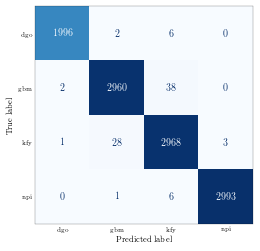

********************************************************************************
Extracting frequency based char (1,8)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.001)

Train and validation time: 1061.2250 seconds

Test time: 0.7351 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9975    0.9970    0.9973      2004
         gbm     0.9826    0.9807    0.9816      3000
         kfy     0.9813    0.9800    0.9807      3000
         npi     0.9950    0.9987    0.9968      3000

    accuracy                         0.9884     11004
   macro avg     0.9891    0.9891    0.9891     11004
weighted avg     0.9884    0.9884    0.9884     11004


Confusion matrix:


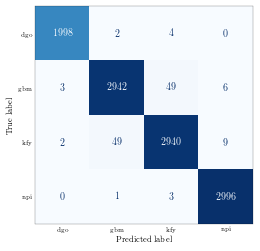

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.1, dual=False)

Train and validation time: 281.6192 seconds

Test time: 0.6196 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9985    0.9960    0.9973      2004
         gbm     0.9896    0.9867    0.9881      3000
         kfy     0.9834    0.9893    0.9864      3000
         npi     0.9990    0.9977    0.9983      3000

    accuracy                         0.9921     11004
   macro avg     0.9926    0.9924    0.9925     11004
weighted avg     0.9921    0.9921    0.9921     11004


Confusion matrix:


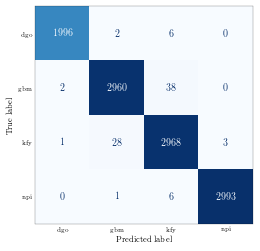

********************************************************************************
Extracting frequency based char (2,2)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: MultinomialNB(alpha=0.01)

Train and validation time: 50.2933 seconds

Test time: 0.1071 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9920    0.9860    0.9890      2004
         gbm     0.9661    0.9603    0.9632      3000
         kfy     0.9643    0.9643    0.9643      3000
         npi     0.9851    0.9950    0.9900      3000

    accuracy                         0.9756     11004
   macro avg     0.9769    0.9764    0.9766     11004
weighted avg     0.9755    0.9756    0.9755     11004


Confusion matrix:


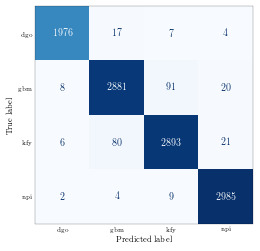

Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.1, dual=False)

Train and validation time: 75.8130 seconds

Test time: 0.1108 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9940    0.9905    0.9923      2004
         gbm     0.9767    0.9770    0.9768      3000
         kfy     0.9721    0.9757    0.9739      3000
         npi     0.9950    0.9933    0.9942      3000

    accuracy                         0.9836     11004
   macro avg     0.9844    0.9841    0.9843     11004
weighted avg     0.9836    0.9836    0.9836     11004


Confusion matrix:


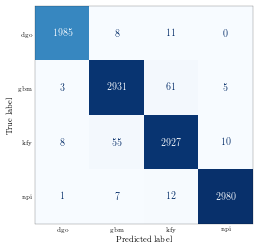

********************************************************************************
Extracting frequency based char (2,3)-gram features...
Training MultinomialNB()
Fitting 5 folds for each of 5 candidates, totalling 25 fits


KeyboardInterrupt: ignored

In [ ]:
dirpath = "/content/drive/MyDrive/PLI/results_github"
results, outputs = build_ngram_model(8)

Train: (44014, 6170)
Test : (11004, 6170)
Training LinearSVC(dual=False)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Estimator: LinearSVC(C=0.01, dual=False)

Train and validation time: 286.5843 seconds

Test time: 0.5822 seconds

Classification report:
              precision    recall  f1-score   support

         dgo     0.9995    0.9960    0.9978      2004
         gbm     0.9900    0.9883    0.9892      3000
         kfy     0.9854    0.9900    0.9877      3000
         npi     0.9987    0.9980    0.9983      3000

    accuracy                         0.9928     11004
   macro avg     0.9934    0.9931    0.9932     11004
weighted avg     0.9928    0.9928    0.9928     11004


Confusion matrix:


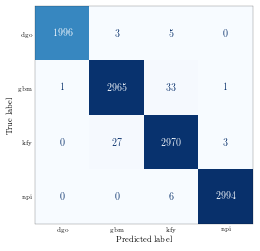

In [ ]:
# save classification report corresponding to the best model: char_14, svm

z = ngrams(term='char', ngram_range=(1, 4), min_df=0.005)
X_tr, X_ts = z['tr_char_14'].toarray(), z['ts_char_14'].toarray()

print("Train:", X_tr.shape)
print("Test :", X_ts.shape)

clf = LinearSVC(dual=False)
params = {'C': np.power(10, np.arange(-3, 2, dtype=float))}
best_param, tr_val_time, ts_time, scores, cm_disp, y_pred = classifier(clf, params, X_tr, y_tr, X_ts, y_ts)

confmx = pd.DataFrame(cm_disp.confusion_matrix, index=label.keys(), columns=label.keys())
output = pd.DataFrame(data={'test sentences': ts_text, 'target': y_ts, 'predicted': y_pred})

In [ ]:
# save the results
scores.to_csv('scores.csv')
confmx.to_csv('confusion_matrix.csv')
output.to_excel('output.xls')